# **Modelo de regresión simple**
## Desarrollado por Jesus David Gomez Osorno
## Universidad de Antioquia

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
RUTA_DATA = '/content/drive/MyDrive/Monografía/data'
RUTA_DATA_MEDIANOS = RUTA_DATA + '/medianos'
RUTA_DATA_GRANDES = RUTA_DATA + '/grandes'
RUTA_RESULTADOS_MEDIANOS = RUTA_DATA + '/resultados/medianos'
RUTA_RESULTADOS_GRANDES = RUTA_DATA + '/resultados/grandes'

## 1. Caracteristicas

In [37]:
DEPARTAMENTO = 'DEPARTAMENTO'
MUNICIPIO = 'MUNICIPIO'
GRUPO_CULTIVO = 'GRUPO_CULTIVO'
CULTIVO = 'CULTIVO'
AREA_SEMBRADA = 'AREA_SEMBRADA'
AREA_COSECHADA = 'AREA_COSECHADA'
PRODUCCION = 'PRODUCCION'
ESTADO_FISICO_PRODUCCION = 'ESTADO_FISICO_PRODUCCION'
CICLO_CULTIVO = 'CICLO_CULTIVO'

In [38]:
columns = [
            DEPARTAMENTO,
            MUNICIPIO,
            GRUPO_CULTIVO,
            CULTIVO,
            AREA_SEMBRADA,
            AREA_COSECHADA,
            PRODUCCION,            
            ESTADO_FISICO_PRODUCCION,
            CICLO_CULTIVO
          ]

columns_feature = [
            DEPARTAMENTO,
            MUNICIPIO,
            GRUPO_CULTIVO,
            CULTIVO,
            AREA_COSECHADA,
            PRODUCCION,            
            ESTADO_FISICO_PRODUCCION,
            CICLO_CULTIVO
          ]

In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

##Función de metricas

In [40]:
from sklearn.model_selection import cross_val_score # Método de validación cruzada para evaluar el desempeño un modelo
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score # Se llama a una clase llamada explained_variance_score, el cual es
                                                     # una métrica de varianza explicada
from sklearn.metrics import mean_absolute_error # Se llama a una clase llamada mean_absolute_error, el cual es
                                                # una métrica de error promedio absoluto
from sklearn.metrics import mean_gamma_deviance # 0.001 (Sensibilidad del modelo regresión)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_poisson_deviance                                            

def puntaje(X_Prueba_local, Y_Prueba_local, y_pred_local, estimador, name):
  Puntaje_1_R2 = estimador.score(X_Prueba_local, Y_Prueba_local) 

  # Error cuadrático medio
  Validacion_ECM = cross_val_score(estimador, X_Prueba_local, Y_Prueba_local, cv = 5, scoring = 'neg_mean_squared_error')
  Puntaje_2_ECM = np.array([Validacion_ECM.mean(), Validacion_ECM.std()]) 

  ## R Cuadrado
  Validacion_R2 = cross_val_score(estimador, X_Prueba_local, Y_Prueba_local, cv = 10, scoring = 'r2')
  Puntaje_3_R2 = np.array([Validacion_R2.mean(), Validacion_R2.std()]) 

  ## Varianza Explicada
  Puntaje_4 = explained_variance_score(Y_Prueba_local, y_pred_local) 
  ## ECM
  Puntaje_5 = mean_absolute_error(Y_Prueba_local, y_pred_local) 

  ## Pérdida media de regresión de la desviación de Poisson
  MN = MinMaxScaler(feature_range=(0, 1))

  Y_Prueba_R = Y_Prueba_local.values
  Y_Prueba_R = np.asarray(Y_Prueba_R)
  Y_merge = np.vstack([Y_Prueba_R, y_pred_local]).T
  Y_merge = MN.fit_transform(Y_merge)

  for _,n in enumerate(np.arange(0, Y_merge.shape[0])):
    if Y_merge[n,0] == 0:
      Y_merge[n,0] = 0.0001
    if Y_merge[n,1] == 0:
      Y_merge[n,1] = 0.0001

  Puntaje_6 = mean_poisson_deviance(Y_merge[:,0], Y_merge[:,1]) 
  Puntaje_7 = mean_gamma_deviance(Y_merge[:,0], Y_merge[:,1])

  return {'NOMBRE': name, 
          'R2_MODEL': Puntaje_1_R2, 
          'CROSS_ECM': Puntaje_2_ECM[0], 
          'CROSS_ECM_DE': Puntaje_2_ECM[1], 
          'CROSS_R2': Puntaje_3_R2[0], 
          'CROSS_R2_DE': Puntaje_3_R2[1],
          'VARIANZA_EXPL': Puntaje_4,
          'MAE': Puntaje_5,
          'MAE_POISSON': Puntaje_6,
          'MAE_GAMMA': Puntaje_7}


## Función grafica mejor

In [41]:
from sklearn.linear_model import LinearRegression # Algoritmo para crear el modelo de regresión lineal múltiple

def grafica_mejor(url):
  data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
  data_after_features = data_after[columns_feature]
  data_after_estimados = data_after[AREA_SEMBRADA]

  X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)

  LR = LinearRegression()
  LR.fit(X_Entrenamiento, Y_Entrenamiento)
  Y_pred = LR.predict(X_Prueba)

  fig = plt.figure(figsize=(12,8))
  line_1 = plt.plot(np.arange(len(Y_Prueba)), Y_Prueba, color = 'g', label='Y original') 
  line_2 = plt.plot(np.arange(len(Y_Prueba)), Y_pred, color = 'r', label='Y estimada por el modelo con regresión simple') 
  plt.axhline(0, color="black") # Elegir color de la linea horizontal de referencia
  plt.legend()
  plt.title('Comparación entre Y salida original vs Y salida del modelo con regresión simple') # Titulo de la gráfica
  plt.xlabel('muestras') # Etiqueta del eje x
  plt.ylabel('y') # Etiqueta del eje y

  plt.show() # Mostrar gráfica

##Función de guardadado de resultados

In [42]:
from os.path import exists

def guardaResultados(url, filename, data):
  if not exists(url):
    np.savetxt(url, data, delimiter=',')

  data_after = pd.read_csv(url, header = None, index_col= False, names = columns_resultados)
  data_after = data_after[data_after['NOMBRE'] == filename ]

  if not len(data_after) > 0:
    print('dentro')
    np.savetxt(url, data, delimiter=',', fmt="%s")
  
  return len(data_after) > 0, pd.concat([data, data_after]);
 

##Medianos

In [43]:
import os
from sklearn.model_selection import train_test_split # Esta clase realiza la partición de datos en entrenamiento y prueba

columns_resultados = ['NOMBRE', 'CONFIG', 'R2_MODEL', 'CROSS_ECM', 'CROSS_ECM_DE', 'CROSS_R2', 'CROSS_R2_DE', 'VARIANZA_EXPL', 'MAE', 'MAE_POISSON', 'MAE_GAMMA']

In [44]:
df_resultados_medianos = pd.DataFrame(columns=columns_resultados, index=None)

for filename in os.listdir(RUTA_DATA_MEDIANOS):
    if filename.endswith("csv"): 
      print(filename)
      is_save, new_data = guardaResultados(RUTA_RESULTADOS_MEDIANOS + '/regresion_simple.csv', filename, df_resultados_medianos )
      df_resultados_medianos = new_data
      if not is_save:
        url = RUTA_DATA_MEDIANOS + '/' + filename
        data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
        data_after_features = data_after[columns_feature]
        data_after_estimados = data_after[AREA_SEMBRADA]
        X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)

        LR = LinearRegression()
        LR.fit(X_Entrenamiento, Y_Entrenamiento)
        Y_pred = LR.predict(X_Prueba)

        result = puntaje(X_Prueba, Y_Prueba, Y_pred, LR, filename)
        df_resultados_medianos = df_resultados_medianos.append(result, ignore_index=True)


robusto_original.csv
estandar_original.csv
min_max_original.csv
max_normalizacion_original.csv
robusto_lof_euclidean_5.csv
robusto_lof_minkowski_5.csv
robusto_lof_manhattan_5.csv
robusto_lof_euclidean_7.csv
robusto_lof_minkowski_7.csv
robusto_lof_manhattan_7.csv
robusto_lof_euclidean_9.csv
robusto_lof_minkowski_9.csv
robusto_lof_manhattan_9.csv
robusto_lof_euclidean_11.csv
robusto_lof_minkowski_11.csv
robusto_lof_manhattan_11.csv
estandar_lof_euclidean_5.csv
estandar_lof_minkowski_5.csv
estandar_lof_manhattan_5.csv
estandar_lof_euclidean_7.csv
estandar_lof_minkowski_7.csv
estandar_lof_manhattan_7.csv
estandar_lof_euclidean_9.csv
estandar_lof_minkowski_9.csv
estandar_lof_manhattan_9.csv
estandar_lof_euclidean_11.csv
estandar_lof_minkowski_11.csv
estandar_lof_manhattan_11.csv
min_max_lof_euclidean_5.csv
min_max_lof_minkowski_5.csv
min_max_lof_manhattan_5.csv
min_max_lof_euclidean_7.csv
min_max_lof_minkowski_7.csv
min_max_lof_manhattan_7.csv
min_max_lof_euclidean_9.csv
min_max_lof_minkows

In [45]:
pd.set_option("min_rows", 20)
df_resultados_medianos_sort = df_resultados_medianos.sort_values('MAE', False)
df_resultados_medianos_sort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  


,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
111,min_max_isf_400_0_2.csv,NaN,0.835214,-0.000010,1.489862e-06,0.833337,0.034245,0.835248,0.001844,0.040983,1.511002
96,min_max_isf_100_0_2.csv,NaN,0.837917,-0.000010,5.012124e-07,0.837448,0.015195,0.837920,0.001861,0.029109,4.900262
101,min_max_isf_200_0_2.csv,NaN,0.830008,-0.000010,1.360899e-06,0.829567,0.031746,0.830023,0.001882,0.035346,0.966900
106,min_max_isf_300_0_2.csv,NaN,0.835896,-0.000010,6.190353e-07,0.835618,0.029403,0.835902,0.001892,0.036218,1.114131
92,min_max_isf_100_auto.csv,NaN,0.856191,-0.000010,1.047104e-06,0.855848,0.029072,0.856222,0.001902,0.028779,0.900309
97,min_max_isf_200_auto.csv,NaN,0.845894,-0.000012,1.630905e-06,0.844599,0.032388,0.845894,0.001953,0.028980,1.193272
107,min_max_isf_400_auto.csv,NaN,0.841609,-0.000011,1.652493e-06,0.841077,0.028991,0.841611,0.001964,0.029858,1.913480
102,min_max_isf_300_auto.csv,NaN,0.834277,-0.000012,2.325841e-06,0.833573,0.032186,0.834312,0.001975,0.031354,0.981105
95,min_max_isf_100_0_15.csv,NaN,0.841044,-0.000015,2.118156e-06,0.840332,0.028973,0.841046,0.002104,0.031065,12.883957
105,min_max_isf_300_0_15.csv,NaN,0.825556,-0.000016,3.096461e-06,0.825651,0.059128,0.825561,0.002120,0.031210,0.880914


### Mejor resultado

In [46]:
df_resultados_medianos_sort.head(1)

,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
111,min_max_isf_400_0_2.csv,NaN,0.835214,-0.00001,0.000001,0.833337,0.034245,0.835248,0.001844,0.040983,1.511002


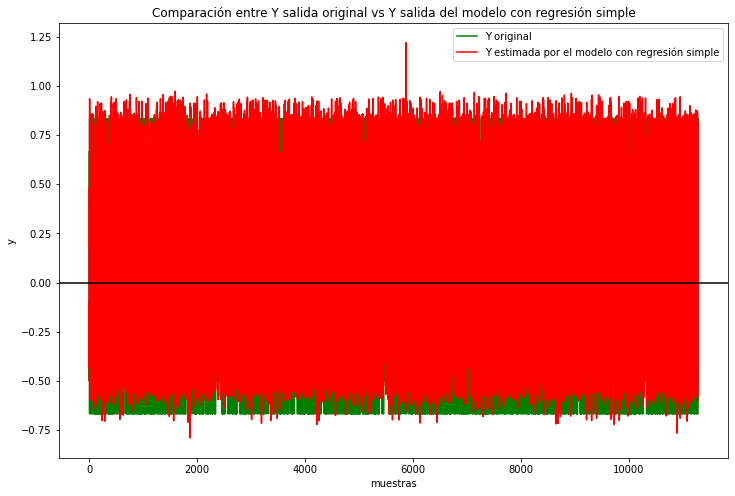

In [47]:
url = RUTA_DATA_MEDIANOS + '/' + df_resultados_medianos_sort.at[0,'NOMBRE']
grafica_mejor(url)

## Grandes

In [48]:
df_resultados_grandes = pd.DataFrame(columns=columns_resultados, index=None)

for filename in os.listdir(RUTA_DATA_GRANDES):
    if filename.endswith("csv"): 
      print(filename)
      is_save, new_data = guardaResultados(RUTA_RESULTADOS_GRANDES + '/regresion_simple.csv', filename, df_resultados_grandes )
      df_resultados_grandes = new_data
      if not is_save:
        url = RUTA_DATA_GRANDES + '/' + filename
        data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
        data_after_features = data_after[columns_feature]
        data_after_estimados = data_after[AREA_SEMBRADA]
        X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)

        LR = LinearRegression()
        LR.fit(X_Entrenamiento, Y_Entrenamiento)
        Y_pred = LR.predict(X_Prueba)

        result = puntaje(X_Prueba, Y_Prueba, Y_pred, LR, filename)
        df_resultados_grandes = df_resultados_grandes.append(result, ignore_index=True)

robusto_original.csv
estandar_original.csv
min_max_original.csv
max_normalizacion_original.csv
robusto_lof_euclidean_5.csv
robusto_lof_minkowski_5.csv
robusto_lof_manhattan_5.csv
robusto_lof_euclidean_7.csv
robusto_lof_minkowski_7.csv
robusto_lof_manhattan_7.csv
robusto_lof_euclidean_9.csv
robusto_lof_minkowski_9.csv
robusto_lof_manhattan_9.csv
robusto_lof_euclidean_11.csv
robusto_lof_minkowski_11.csv
robusto_lof_manhattan_11.csv
estandar_lof_euclidean_5.csv
estandar_lof_minkowski_5.csv
estandar_lof_manhattan_5.csv
estandar_lof_euclidean_7.csv
estandar_lof_minkowski_7.csv
estandar_lof_manhattan_7.csv
estandar_lof_euclidean_9.csv
estandar_lof_minkowski_9.csv
estandar_lof_manhattan_9.csv
estandar_lof_euclidean_11.csv
estandar_lof_minkowski_11.csv
estandar_lof_manhattan_11.csv
min_max_lof_euclidean_5.csv
min_max_lof_minkowski_5.csv
min_max_lof_manhattan_5.csv
min_max_lof_euclidean_7.csv
min_max_lof_minkowski_7.csv
min_max_lof_manhattan_7.csv
min_max_lof_euclidean_9.csv
min_max_lof_minkows

In [49]:
pd.set_option("min_rows", 20)
df_resultados_grandes_sort = df_resultados_grandes.sort_values('MAE', False)
df_resultados_grandes_sort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  


,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
37,min_max_lof_euclidean_11.csv,NaN,0.958669,-0.000031,0.000015,0.958005,0.027739,0.958669,0.001388,0.001891,1.115753
38,min_max_lof_minkowski_11.csv,NaN,0.958669,-0.000031,0.000015,0.958005,0.027739,0.958669,0.001388,0.001891,1.115753
29,min_max_lof_minkowski_5.csv,NaN,0.954161,-0.000040,0.000013,0.957298,0.032225,0.954162,0.001388,0.002522,1.304483
28,min_max_lof_euclidean_5.csv,NaN,0.954161,-0.000040,0.000013,0.957298,0.032225,0.954162,0.001388,0.002522,1.304483
30,min_max_lof_manhattan_5.csv,NaN,0.964887,-0.000031,0.000016,0.966605,0.018884,0.964889,0.001391,0.001942,1.261576
34,min_max_lof_euclidean_9.csv,NaN,0.955094,-0.000039,0.000009,0.949360,0.032898,0.955095,0.001403,0.002201,1.171780
35,min_max_lof_minkowski_9.csv,NaN,0.955094,-0.000039,0.000009,0.949360,0.032898,0.955095,0.001403,0.002201,1.171780
39,min_max_lof_manhattan_11.csv,NaN,0.959592,-0.000035,0.000024,0.962075,0.023371,0.959592,0.001409,0.002368,1.238260
32,min_max_lof_minkowski_7.csv,NaN,0.952003,-0.000041,0.000009,0.954734,0.023106,0.952004,0.001419,0.002378,1.268572
31,min_max_lof_euclidean_7.csv,NaN,0.952003,-0.000041,0.000009,0.954734,0.023106,0.952004,0.001419,0.002378,1.268572


### Mejor resultado

In [50]:
df_resultados_grandes_sort.head(1)

,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
37,min_max_lof_euclidean_11.csv,NaN,0.958669,-0.000031,0.000015,0.958005,0.027739,0.958669,0.001388,0.001891,1.115753


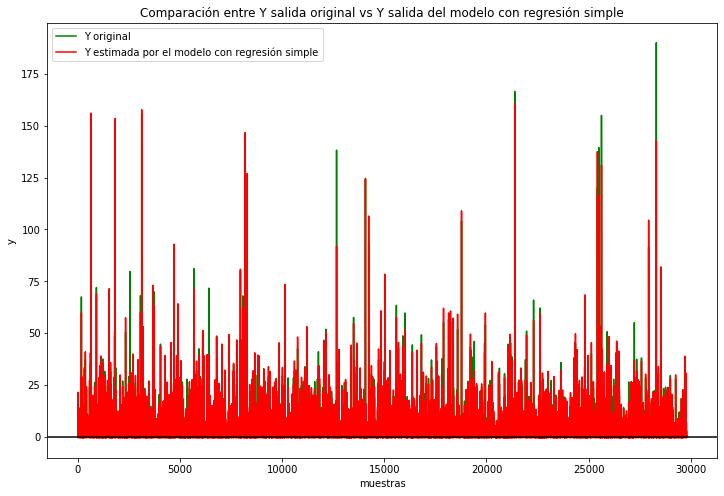

In [51]:
url = RUTA_DATA_GRANDES + '/' + df_resultados_grandes_sort.at[0,'NOMBRE']
grafica_mejor(url)